In [11]:
import pandas as pd
import numpy as np
import re
import ast
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


## Loading Scraped Data

In [12]:
pcmasterrace_df = pd.read_csv('./data/pcmasterraceDataFrame.csv',index_col=0)
pcmasterrace_df['data'] = pcmasterrace_df['data'].map(lambda x: ast.literal_eval(x)) # Converting str col into dic

In [13]:
mac_df = pd.read_csv('./data/macDataFrame.csv',index_col=0)
mac_df['data'] = mac_df['data'].map(lambda x: ast.literal_eval(x)) # Converting str col into dic

In [14]:
pcmasterrace_df.shape

(997, 7)

In [15]:
pcmasterrace_df.head()

,kind,data,subreddit,title,name,selftext,domain
0,t3,"{'approved_at_utc': None, 'subreddit': 'pcmast...",pcmasterrace,Folding@Home and PCMR team up! Use your PC to ...,t3_dln0o3,"This is the 8th iteration of this thread, sinc...",self.pcmasterrace
1,t3,"{'approved_at_utc': None, 'subreddit': 'pcmast...",pcmasterrace,I spent all night alone at the MSI CES booth w...,t3_es1t4h,NaN,youtube.com
2,t3,"{'approved_at_utc': None, 'subreddit': 'pcmast...",pcmasterrace,A funny title,t3_esooh7,NaN,i.redd.it
3,t3,"{'approved_at_utc': None, 'subreddit': 'pcmast...",pcmasterrace,One of the madlad electricians at work made a ...,t3_esdg5b,NaN,i.redd.it
4,t3,"{'approved_at_utc': None, 'subreddit': 'pcmast...",pcmasterrace,"Linus reached 10 million, but is thinking of r...",t3_esp0ju,NaN,i.redd.it


In [16]:
mac_df.shape

(1000, 7)

In [17]:
mac_df.head()

,kind,data,subreddit,title,name,selftext,domain
0,t3,"{'approved_at_utc': None, 'subreddit': 'mac', ...",mac,"Picked up an ‘09 5,5 for $86",t3_esicey,NaN,i.imgur.com
1,t3,"{'approved_at_utc': None, 'subreddit': 'mac', ...",mac,Window peel frosting makes for the perfect mou...,t3_es5imf,NaN,i.redd.it
2,t3,"{'approved_at_utc': None, 'subreddit': 'mac', ...",mac,I prefer the Macbook Pro 2018 over my Razer Bl...,t3_esogm2,"Hey, y'all. I am a programming student and pur...",self.mac
3,t3,"{'approved_at_utc': None, 'subreddit': 'mac', ...",mac,My Mac editing suite is finished and the wife ...,t3_esod1h,NaN,i.redd.it
4,t3,"{'approved_at_utc': None, 'subreddit': 'mac', ...",mac,Don't know why I can't find a simple solution....,t3_esppmj,On my iPhone I use Aloha app and use their bro...,self.mac


## Removing Duplicate Rows

In [18]:
pcmasterrace_df.drop_duplicates(subset=['subreddit', 'title', 'name', 'selftext', 'domain'],keep='first', inplace=True)
mac_df.drop_duplicates(subset=['subreddit', 'title', 'name', 'selftext', 'domain'],keep='first', inplace=True)

## Checking No. of Rows

In [19]:
print("pcmasterrace", pcmasterrace_df.shape)
print("mac", mac_df.shape)

pcmasterrace (970, 7)
mac (1000, 7)


Insights:

1. Both data frames have more than 900 rows. There is enough data to train a model.
2. Frequency of classes are similar. There is no need to stratify or correct for imbalanced data.

## Replacing nulls with string null:

In [20]:
#Replacing null with 'null'
pcmasterrace_df['selftext'].fillna('null9999', inplace=True) 
mac_df['selftext'].fillna('null9999', inplace=True)

### Insights:
    
1. Some models might not accept rows with null values.
2. Replacing them with null string should fix that and not affect model prediction.

## Joining Dataframes and Creating Columns

In [21]:
final_df = pd.concat([pcmasterrace_df, mac_df], axis=0, join='outer',ignore_index=False)
final_df = final_df.reset_index(drop=True)

### Creating new columns from website information:

In [22]:
final_df['ups'] = final_df['data'].map(lambda x: x['ups'])
final_df['num_comments'] = final_df['data'].map(lambda x: x['num_comments'])
final_df['author'] = final_df['data'].map(lambda x: x['author'])

### Creating Label column:

In [23]:
final_df['label'] = final_df['subreddit'].map({'pcmasterrace':0,'mac':1})

### Removing un-used columns:

In [24]:
drop_columns = ['data','kind','domain','name','subreddit']
final_df.drop(columns=drop_columns,axis=1,inplace=True)

### Insights:

1. The number of ups, comments and author name might be useful for predictions.
2. The 2 data frames can be merged together since they have the similar information for different classes.
3. The label column will be the predicted variable.The value is equal to 1 if text is from mac subredit.

### Removing space,tab and breakline and stop words:

In [25]:
nltk.download()  # Download text data sets, including stop words. Uncomment this if you did not download

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [26]:
def clean_text(text_to_clean):
    text_to_clean = re.sub( '[^a-zA-Z0-9]', ' ', text_to_clean) # subs charact in the brackets
    text_to_clean = re.sub( '\s+', ' ', text_to_clean).strip() ## subs tabs,newlines and "whitespace-like"
    words = text_to_clean.lower().split() ## convert to lowercase split indv words
    stops = set(stopwords.words('english')) #converting stop words to set
    meaningful_words = [w for w in words if not w in stops] # removing stop words
    return(" ".join(meaningful_words))

In [27]:
final_df['clean_title'] = final_df.apply(lambda x: clean_text(x['title']), axis=1)
final_df['clean_selftext'] = final_df.apply(lambda x: clean_text(x['selftext']), axis=1)

### Insights:

1. Double space, tabs and break lines usually are not useful for preditions.

### Counting Nulls:

In [28]:
print("Total nulls:" , final_df.isnull().sum().sum())

Total nulls: 0


### Printing and checking class distribution:

In [29]:
display(final_df.head(2))
print("Final shape is: ", final_df.shape)
display("Class count: ", final_df['label'].value_counts())
display("Class percentage: ",final_df['label'].value_counts(normalize=True))

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext
0,Folding@Home and PCMR team up! Use your PC to ...,"This is the 8th iteration of this thread, sinc...",1066,148,pedro19,0,folding home pcmr team use pc help scientists ...,8th iteration thread since 6 months reddit arc...
1,I spent all night alone at the MSI CES booth w...,null9999,154,19,pedro19,0,spent night alone msi ces booth wearing onesie...,null9999


Final shape is:  (1970, 8)


'Class count: '

1    1000
0     970
Name: label, dtype: int64

'Class percentage: '

1    0.507614
0    0.492386
Name: label, dtype: float64

### Checking most comon words for each class:

In [30]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [31]:
#pcmasterrace
split_pcmasterrace_series = final_df.loc[final_df['label']==1,:]['clean_title'].str.split()
words_pcmasterrace = []
for value in split_pcmasterrace_series:
    words_pcmasterrace = words_pcmasterrace + value
print("pcmasterrace word count length:", len(words_pcmasterrace))

#mac
split_mac_series = final_df.loc[final_df['label']==0,:]['clean_title'].str.split()
words_mac = []
for value in split_mac_series:
    words_mac = words_mac + value
print("mac word count length:", len(words_mac))
display("mac title common words",sortFreqDict(wordListToFreqDict(words_pcmasterrace))[0:15])
display("pcmasterrace title common words",sortFreqDict(wordListToFreqDict(words_mac))[0:15])

pcmasterrace word count length: 7108
mac word count length: 5895


'mac title common words'

[(279, 'macbook'),
 (225, 'pro'),
 (214, 'mac'),
 (96, 'imac'),
 (83, 'help'),
 (64, 'new'),
 (50, '2019'),
 (47, 'air'),
 (45, 'screen'),
 (44, '16'),
 (42, 'mbp'),
 (40, 'apple'),
 (39, 'need'),
 (37, 'get'),
 (35, 'anyone')]

'pcmasterrace title common words'

[(155, 'pc'),
 (84, 'build'),
 (81, 'new'),
 (68, 'help'),
 (54, 'gpu'),
 (53, 'first'),
 (47, 'monitor'),
 (41, 'cpu'),
 (39, 'need'),
 (36, 'get'),
 (34, 'good'),
 (32, 'gaming'),
 (28, 'one'),
 (25, 'upgrade'),
 (25, 'time')]

## Steaming and Lemmatizing
- In NPL steaming text can improve models.
- Will create 3 new columns one for each steaming method.

### Creating stemming Function:

In [32]:
porter=PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

def stemtext(sentence,steamer):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        if (str(steamer) == '<WordNetLemmatizer>'):
            stem_sentence.append(steamer.lemmatize(word))
        else:
            stem_sentence.append(steamer.stem(word))

        stem_sentence.append(" ")
    return "".join(stem_sentence)

### Using function to create stemming columns:

In [33]:
# For title column
final_df['clean_title_lemmat'] = final_df.apply(lambda x: stemtext(x['clean_title'], WordNetLemmatizer()), axis=1)
final_df['clean_title_lancast'] = final_df.apply(lambda x: stemtext(x['clean_title'], LancasterStemmer()), axis=1)
final_df['clean_title_port'] = final_df.apply(lambda x: stemtext(x['clean_title'],PorterStemmer()), axis=1)

In [34]:
# For self text column
final_df['clean_selftext_lemmat'] = final_df.apply(lambda x: stemtext(x['clean_title'], WordNetLemmatizer()), axis=1)
final_df['clean_selftext_lancast'] = final_df.apply(lambda x: stemtext(x['clean_title'], LancasterStemmer()), axis=1)
final_df['clean_selftext_port'] = final_df.apply(lambda x: stemtext(x['clean_title'],PorterStemmer()), axis=1)

In [35]:
#Checking data frame
final_df.head()

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext,clean_title_lemmat,clean_title_lancast,clean_title_port,clean_selftext_lemmat,clean_selftext_lancast,clean_selftext_port
0,Folding@Home and PCMR team up! Use your PC to ...,"This is the 8th iteration of this thread, sinc...",1066,148,pedro19,0,folding home pcmr team use pc help scientists ...,8th iteration thread since 6 months reddit arc...,folding home pcmr team use pc help scientist b...,fold hom pcmr team us pc help sci beat cant al...,fold home pcmr team use pc help scientist beat...,folding home pcmr team use pc help scientist b...,fold hom pcmr team us pc help sci beat cant al...,fold home pcmr team use pc help scientist beat...
1,I spent all night alone at the MSI CES booth w...,null9999,154,19,pedro19,0,spent night alone msi ces booth wearing onesie...,null9999,spent night alone msi ce booth wearing onesie ...,spent night alon msi ces boo wear onesy also s...,spent night alon msi ce booth wear onesi also ...,spent night alone msi ce booth wearing onesie ...,spent night alon msi ces boo wear onesy also s...,spent night alon msi ce booth wear onesi also ...
2,A funny title,null9999,2500,73,iDavidindahouse,0,funny title,null9999,funny title,funny titl,funni titl,funny title,funny titl,funni titl
3,One of the madlad electricians at work made a ...,null9999,39327,1040,LTCodus,0,one madlad electricians work made 150 foot ret...,null9999,one madlad electrician work made 150 foot retr...,on madlad elect work mad 150 foot retract ethe...,one madlad electrician work made 150 foot retr...,one madlad electrician work made 150 foot retr...,on madlad elect work mad 150 foot retract ethe...,one madlad electrician work made 150 foot retr...
4,"Linus reached 10 million, but is thinking of r...",null9999,412,69,AmdMakesaDifference,0,linus reached 10 million thinking retiring,null9999,linus reached 10 million thinking retiring,lin reach 10 mil think retir,linu reach 10 million think retir,linus reached 10 million thinking retiring,lin reach 10 mil think retir,linu reach 10 million think retir


## Dealing with empty rows post lemmatizing:
- After lemmatizer the row 825 had no word in the title.
- Dropping drop of 1 row will not have significant affect in the model.

In [36]:
#droping column where lemmatizer left no text
display(final_df[final_df['clean_title'].str.len()< 1])
final_df = final_df[~(final_df['clean_title'].str.len()< 1)]

,title,selftext,ups,num_comments,author,label,clean_title,clean_selftext,clean_title_lemmat,clean_title_lancast,clean_title_port,clean_selftext_lemmat,clean_selftext_lancast,clean_selftext_port
825,how,how do you fancy dudes put your system specs n...,3,7,pandason89,0,,fancy dudes put system specs next usernames,,,,,,


- During the regression mac and pc root words will be removed
- These words make too easy for the model to predict.

## Creating Word Cloud:

In [37]:
# # Start with one review:
# text = final_df['clean_title'][2]
# Join all titles of each Computer OS:
mac = " ".join(review for review in final_df[final_df["label"]==1]['clean_title'])
pcmasterrace = " ".join(review for review in final_df[final_df["label"]==0]['clean_title'])

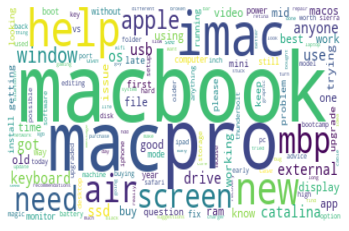

In [38]:
# mac
# Join all titles:
mac = " ".join(review for review in final_df[final_df["label"]==1]['clean_title'])
#Create and generate a word cloud image:
wordcloud_mac = WordCloud(collocations=False,background_color="white", max_words=150).generate(mac)

# Display the generated image:
plt.imshow(wordcloud_mac, interpolation='bilinear',aspect="auto")
plt.axis("off")
# store to file
plt.savefig("./images/mac_word_cloud.png", format="png")
plt.show()

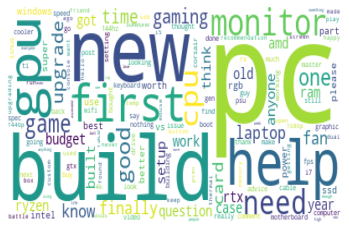

In [39]:
# Toyota
# Join all titles:
pcmasterrace = " ".join(review for review in final_df[final_df["label"]==0]['clean_title'])
# Create and generate a word cloud image:
wordcloud_pcmasterrace = WordCloud(collocations=False,background_color="white", max_words=150).generate(pcmasterrace)

# Display the generated image:
plt.imshow(wordcloud_pcmasterrace, interpolation='bilinear',aspect="auto")
plt.axis("off")

# store to file
plt.savefig('./images/pcmasterrace_word_cloud.png', format="png")

# show image
plt.show()

## Saving data in CSV

In [40]:
final_df.to_csv('./data/final_df.csv', encoding='utf-8',index_label=False)